In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Lower level imports
from LowerLevel.pdhg import pdhg

#Upper level imports
import time
from UpperLevel.LBFGSB import *
from UpperLevel.cost_utils import *

### Creation of Lower level tools
Creating fourier_op, linear_op and param.

In [3]:
n = 50

n_rad = int( n/2 )
n_ang = int( n/2 )

#num_blocks = ( n_rad - 1 ) * n_ang + 1 # for sampling isolated points
num_blocks = n_ang # for choosing radia
#num_blocks = n_rad # for choosing circles
nb_samples = int( num_blocks * 2 / np.pi )

phi = np.linspace( 0, 2 * np.pi, n_ang, endpoint = False )
rad = np.linspace( 0.5 / n_rad, 0.5, (n_rad-1), endpoint = False )
Phi, Rad = np.meshgrid( phi, rad )

X = ( Rad * np.cos( Phi ) ).flatten( 'C' )
Y = ( Rad * np.sin( Phi ) ).flatten( 'C' )

full_kspace_loc = np.stack( ( X, Y ), axis = 1 )  
full_kspace_loc = np.vstack( ( np.array( [ 0, 0 ] ), full_kspace_loc ) )

m = convert_locations_to_mask(full_kspace_loc,(n,n))
fourier_op = NonCartesianFFT(samples=full_kspace_loc, shape=(n,n),implementation='cpu')

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [4]:
#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=1,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

param = {"epsilon":1e-4,"gamma":1e-10}

### Initializing upper level
Creating images, kspace_data and updating param

In [5]:
#Oasis image
all_images = [ "oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii"]
              #,"../oasis_data/sub-OAS30278_ses-d1325_run-02_T1w.nii" ]
im = nib.load("oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii")
im = im.get_fdata()

Nimages = 1
images = [(1+0j)*im[ :, 30:206, i ]for i in range(124,124+Nimages)]

In [6]:
def reduce_img_size( n_dim, image ):
    mid = image.shape[ 0 ] // 2
    f_coef = np.fft.fftshift( np.fft.fft2( image ) )
    reduced_coef = f_coef[ mid - n_dim // 2: mid + n_dim // 2, mid - n_dim // 2: mid + n_dim // 2 ]
    reduced_image = np.fft.ifft2( np.fft.fftshift( reduced_coef ) )
    return np.abs( reduced_image )

images = [reduce_img_size(n,im) for im in images]
kspace_data = [(1+0j)*fourier_op.op(u0_mat) + 
               0.1*np.mean(u0_mat)*np.random.randn(2*(n_rad-1)*n_ang+2).view(np.complex128) 
               for u0_mat in images]

In [7]:
param["c"] = 1e-8
param["beta"] = 1e-4

In [11]:
# -- Main object to learn mask --
# -------------------------------
obj = Mask_Learner(images=images,kspace_data=kspace_data,
                    fourier_op=fourier_op , linear_op=linear_op , param=param , 
                    verbose=-1 , const={"sigma":0.1,"tau":10})

## Learning points

In [27]:
p0 = np.random.rand(n_ang*(n_rad-1)+2)
p0[-1] = 1e-3

print("Penalty:",P(p0,param["beta"]))
print("Total energy:",E(pk = p0 , images = images , kspace_data = kspace_data , param = param , 
       mask_type = "radial" , fourier_op = fourier_op , linear_op = linear_op , verbose = -1 ,
       const = obj.const))

Penalty: 0.041962036140938706
Total energy: 4.2395662765149265


In [28]:
pf,energy_upper,alphas = obj.optimize(p0=p0 , mask_type="radial")


1 iterations: E(p)=3.841406323447397, alpha=0.9873749195456951



2 iterations: E(p)=3.7281946951956972, alpha=1.5645091722345295



3 iterations: E(p)=3.6396976499675646, alpha=2.283504818778975



4 iterations: E(p)=3.520613476187012, alpha=3.4444034434441617



5 iterations: E(p)=3.4354270296402554, alpha=4.671713728431327



6 iterations: E(p)=3.4235757592328797, alpha=6.528194525144423



FINISHED IN 151.75709676742554 SECONDS



4.2395662765149265 3.4235757592328797


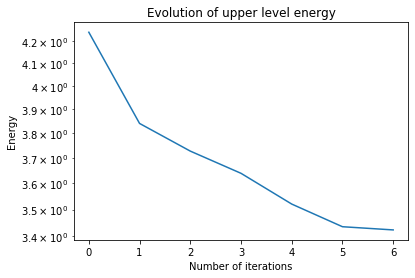

In [29]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/convergence.png")

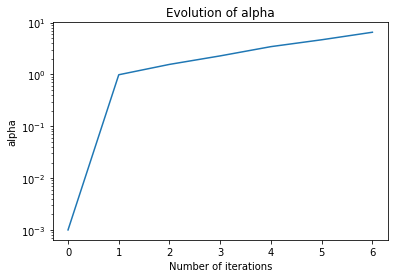

In [30]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/alpha.png")

In [36]:
ptot = np.ones((n_rad-1)*n_ang+2)
ptot[-1] = pf[-1]
print("Penalty:",P(ptot,param["beta"]))
print("Total energy:",E(pk = ptot , images = images , kspace_data = kspace_data , param = param , 
       mask_type = "radial" , fourier_op = fourier_op , linear_op = linear_op , verbose = -1 ,
       const = obj.const))

Penalty: 0.04258791356162281
Total energy: 3.502460862296826


In [32]:
# -- Compute mean ssim of final mask and its ceiled version --
ceiled_pf = np.where(pf>0.5,1,0)
ceiled_pf[-1]=pf[-1]

mean_ssim_pf = 0
mean_ssim_ceiled = 0

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const , mask_type = "radial")
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")


Mean ssim: 0.8057732291145008
Mean ssim ceiled mask:0.24112116009563478


In [37]:
ceiled_mask = []
for i in range(len(pf)-1):
    if ceiled_pf[i]==1:
        ceiled_mask.append(full_kspace_loc[i])
pysap.Image(data = convert_locations_to_mask(np.array(ceiled_mask),(n,n))).show()